In [1]:
#from keras_facenet import FaceNet
from scipy import misc
#from mtcnn.mtcnn import MTCNN
import mxnet as mx

In [2]:
import cv2
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from imageio import imread
from skimage.transform import resize
from scipy.spatial import distance
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import skimage
from sklearn.utils import shuffle
import pandas as pd
import sklearn
import os
import math

import time
from imutils import face_utils

In [4]:
from AIengine import *
ai_engine = AIengine('./models')

./models/model.pkl
Loading AI Engine


In [5]:
from align_dlib import *

In [5]:
dlib_model = AlignDlibFast('./models/shape_predictor_5_face_landmarks.dat')

In [6]:
net = cv2.dnn.readNetFromCaffe('./cv2/deploy.prototxt.txt', './cv2/res10_300x300_ssd_iter_140000.caffemodel')

In [39]:
def random_rotate_image(image):
    angle = np.random.uniform(low=-10.0, high=10.0)
    return skimage.transform.rotate(image, angle, 'bicubic')

def rotate_image(image, angle = 0):
    return skimage.transform.rotate(image, angle, 'bicubic')
  
def face_extract_dnn(img, margin=10, image_size=160, model=cv2_face_detector):
    try:
        t = time.time()
        (h, w) = img.shape[:2]
        blob = cv2.dnn.blobFromImage(cv2.resize(img, (image_size, image_size)), 1.0, (image_size, image_size), (103.93, 116.77, 123.68))
        model.setInput(blob)
        detections = model.forward()
        confidence = detections[0, 0, 0, 2]
        #print(detections)
        if confidence >= 0.55:
            box = detections[0, 0, 0, 3:7] * np.array([w, h, w, h])
            (x, y, p, q) = box.astype('int')
            (y1, y2, x1, x2) = (y-margin//2,q+margin//2, x-margin//2,p+margin//2)
            (x1, y1) = [0 if i<0 else i for i in (x1, y1)]
            faceDetected = (x1, y1, x2, y2) 
            cropped = img[y1:y2, x1:x2, :]
            _img = resize(cropped, (112, 112),
                          mode='reflect')
            #print(time.time()-t)
            return _img, faceDetected
        else:
            return img, False
    except Exception as e:
        print("Error in face_extract_dnn")
        print(e)
        return img, False
    return None

def face_extract_dlib(img, margin=70, image_size=160):
    try:
        # print(faces[0].dtype)
        cropped = dlib_model.align_and_crop(image_size, img, margin=margin)
        img = resize(cropped, (image_size, image_size), mode='reflect')
    except Exception as e:
        print("error in face detection")
        print(e)
        img = resize(img, (image_size, image_size), mode='reflect')
        faceDetected = False
    return img, faceDetected

mtcnn_model = None#MTCNN()

def face_extract_mtcnn(img, margin=0, image_size=160, model=mtcnn_model):
    try:
        t = time.time()
        detections = model.detect_faces(img)
        print(detections)
        confidence = [i['confidence'] for i in detections][0]
        if confidence >= 0.55:
            box = detections[0]['box']
            (x, y, p, q) = box
            (y1, y2, x1, x2) = (y-margin//2,q+y+margin//2, x-margin//2,p+x+margin//2)
            (x1, y1) = [0 if i<0 else i for i in (x1, y1)]
            faceDetected = (x1, y1, x2, y2) 
            cropped = img[y1:y2, x1:x2, :]
            _img = resize(cropped, (image_size, image_size), mode='reflect')
            #print(time.time()-t)
            return _img, faceDetected
        else:
            return img, False
    except Exception as e:
        print("Error in face_extract_dnn")
        print(e)
        print("\t\t" + str(confidence) + " " + str(faceDetected))
        return img, False
    return None

cascade = cv2.CascadeClassifier('./cv2/haarcascade_frontalface_alt2.xml')
def face_extract_haar(img, margin=70, image_size=160, cascade = cascade):
    try:
        t = time.time()
        faces = cascade.detectMultiScale(img,
                                         scaleFactor=1.1,
                                         minNeighbors=3)
        (x, y, w, h) = faces[0]
        faceDetected = (x, y, w, h)
        print(faceDetected)
        # print(faces[0].dtype)
        cropped = img[y-margin//2:y+h+margin//2,
                      x-margin//2:x+w+margin//2, :]
        print(cropped.shape)
        img = resize(cropped, (image_size, image_size), mode='reflect')
    except Exception as e:
        print("error in face detection")
        print(e)
        img = resize(img, (image_size, image_size), mode='reflect')
        faceDetected = False
    #print(time.time()-t)
    return img, faceDetected

def prewhiten(x):
        if x.ndim == 4:
            axis = (1, 2, 3)
            size = x[0].size
        elif x.ndim == 3:
            axis = (0, 1, 2)
            size = x.size
        else:
            raise ValueError('Dimension should be 3 or 4')

        mean = np.mean(x, axis=axis, keepdims=True)
        std = np.std(x, axis=axis, keepdims=True)
        std_adj = np.maximum(std, 1.0/np.sqrt(size))
        y = (x - mean) / std_adj
        return y

def preprocess(images, margin=10, image_size=160, model_path='./cv2/haarcascade_frontalface_alt2.xml', face_extract_algo=face_extract_dnn):
        try:
            #t = time.time()
            faceDetected = True
            aligned_images = []
            for img in images:
                # print(filepath)
                if type(img) is list:
                    img = np.array(img)
                img = to_rgb(img)
                #print("Time till init...")
                #print(time.time() - t)
                aligned = None#dlib_model.align(img)#align_face(img)
                if aligned is None:
                    #print("dlib couldn't find any face, using dnn...")
                    #print(type(aligned))
                    #plt.imshow(img)
                    #plt.show()
                    #continue
                    aligned = img
                #print("Time till dlib align...")
                #print(time.time() - t)
                _img, faceDetected = face_extract_dnn(aligned, margin, image_size = image_size)#face_extract_dnn(img, margin)
                #print("Time till face extract...")
                #print(time.time() - t)
                if faceDetected is False:
                    print("No face detected")
                    print(type(aligned))
                    plt.imshow(img)
                    plt.show()
                    continue
                aligned_images.append(_img)
            if len(aligned_images) == 0:
                return images, False
            #print(time.time() - t)
            return np.array(aligned_images), faceDetected
        except Exception as e:
            print("Error in Preprocess ")
            print(e)
            return images, False

In [28]:

def align_and_crop_face(image, desiredLeftEye=(0.35, 0.35), desiredFaceWidth = 160, desiredFaceHeight = 160):
    t = time.time()
    detection = mtcnn_model.detect_faces(img)[0]
    confidence = detection['confidence']
    if confidence <= 0.4:
        print("No face found!")
        return None
    (x1, y1) = detection['keypoints']['left_eye']
    (x2, y2) = detection['keypoints']['right_eye']
    (x, y, p, q) = detection['box']
    dX = float(x2 - x1)
    dY = float(y2 - y1)
    angle = (math.atan(dY/dX)*180)/math.pi
    dist = np.sqrt((dX ** 2) + (dY ** 2))
    desiredRightEyeX = 1.0 - desiredLeftEye[0]
    desiredDist = (desiredRightEyeX - desiredLeftEye[0])
    desiredDist *= desiredFaceWidth
    scale = desiredDist / dist
    rotationCenter = ((x1 + x2) // 2, (y1 + y2) // 2)
    M = cv2.getRotationMatrix2D(rotationCenter, angle, scale)
    tX = desiredFaceWidth * 0.5
    tY = desiredFaceHeight * desiredLeftEye[1]
    M[0, 2] += (tX - rotationCenter[0])
    M[1, 2] += (tY - rotationCenter[1])
    # apply the affine transformation
    (w, h) = (desiredFaceWidth, desiredFaceHeight)
    output = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)
    #print(time.time()-t)
    return output

def align_face(image):
    t = time.time()
    try:
        detection = mtcnn_model.detect_faces(image)[0]
        confidence = detection['confidence']
        if confidence <= 0.4:
            print("No face found!")
            return image, False
        (x1, y1) = detection['keypoints']['left_eye']
        (x2, y2) = detection['keypoints']['right_eye']
        (x, y, p, q) = detection['box']
        dX = float(x2 - x1)
        dY = float(y2 - y1)
        angle = (math.atan(dY/dX)*180)/math.pi
        return (rotate_image(image, angle)*255).astype('uint8'), True
    except Exception as e:
        print("Alignment failed")
        print(e)
        return image, False

def rotate_image_scalfree(img, angle):
    rotationCenter = img.shape[0]/2, img.shape[1]/2
    M = cv2.getRotationMatrix2D(rotationCenter, angle, 1)
    tX = 160 * 0.5
    tY = 160 * 0.5#desiredLeftEye[1]
    M[0, 2] += (tX - rotationCenter[0])
    M[1, 2] += (tY - rotationCenter[1])
    # apply the affine transformation
    (w, h) = (160, 160)
    output = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC)
    return output
    

In [9]:
cv2.destroyAllWindows()
import dlib
INNER_EYES_AND_BOTTOM_LIP = [3, 1, 4]

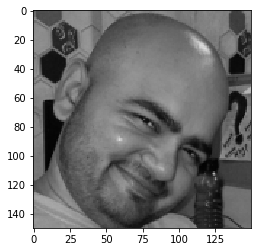

None
[(0, 0) (150, 150)]
0.016511201858520508


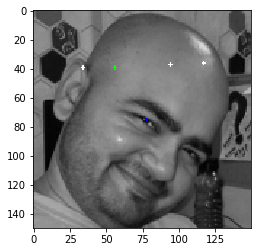

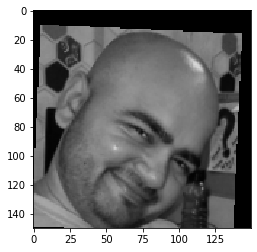

In [26]:
#

#img = to_rgb(imread('images/Train/Harendra/Harendra.png'))
#img = to_rgb(imread('images/Train/Davinder/Davinder.1.jpg'))
img = to_rgb(cv2.imread('images/Train/Harendra/Harendra.png'))
plt.imshow(img)
plt.show()
t = time.time()
#print(time.time() - t)
bb = dlib_model.getLargestFaceBoundingBox(img)
print(bb)
bb = dlib.rectangle(0, 0, 150, 150)
print(bb)
#print(time.time() - t)
landmarks = dlib_model.predictor(img, bb)
#print(time.time() - t)
#npLandmarks = np.float32(landmarks)
#npLandmarkIndices = np.array(INNER_EYES_AND_BOTTOM_LIP)
#x, y, w, h = face_utils.rect_to_bb(bb)

scale = 1.0
imgDim = 150
#H = cv2.getAffineTransform(npLandmarks[npLandmarkIndices], imgDim * MINMAX_TEMPLATE[npLandmarkIndices]*scale + imgDim*(1-scale)/2)
#thumbnail = cv2.warpAffine(img, H, (imgDim, imgDim))
#faces = dlib.full_object_detections()
#faces.append(landmarks)
#print(faces)
thumbnail = dlib.get_face_chip(img, landmarks)
#print(time.time() - t)

#print("Just align")
#t = time.time()
#ff = dlib_model.align(img)
#print(time.time() - t)

#cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 1)
color = [(255,255,255), (255,255,255), (255, 255, 255), (0, 255, 0), (0, 0, 255)]
landmarks = [(p.x, p.y) for p in landmarks.parts()]
for (i, (x, y)) in enumerate(landmarks):
    cv2.circle(img, (x, y), 1, color[i], -1)
plt.imshow(img)
plt.show()


#bb = dlib_model.getLargestFaceBoundingBox(thumbnail)
#x, y, w, h = face_utils.rect_to_bb(bb)
#cv2.rectangle(thumbnail, (x, y), (x + w, y + h), (0, 255, 0), 1)

plt.imshow(thumbnail)
plt.show()

(1, 112, 112, 3)


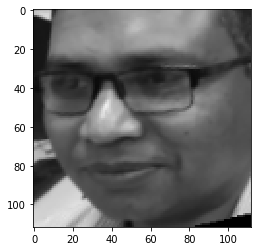

In [22]:
img = to_rgb(imread('images/Train/Suresh/Suresh3.png'))
face, status = preprocess([img])#dlib_model.align(img)#face_extract_dnn(align_face((rotate_image(img, 0)*255).astype('uint8')))
print(face.shape)
plt.imshow(face[0])

In [13]:
ctx = mx.gpu(0)
sym, arg_params, aux_params = mx.model.load_checkpoint('./models/arcface', 0)
all_layers = sym.get_internals()
sym = all_layers['fc1_output']
model = mx.mod.Module(symbol=sym, context=ctx, label_names = None)
model.bind(data_shapes=[('data', (1, 3, 112, 112))])
model.set_params(arg_params, aux_params)

In [51]:
t = time.time()
face_img = np.array(face[0])
if face_img.dtype != 'uint8':
    nimg = (face_img*255).astype('uint8')
else:
    nimg = face_img
print("init...")
print(time.time()-t)
#nimg = cv2.cvtColor(nimg, cv2.COLOR_BGR2RGB)
aligned = np.transpose(nimg, (2,0,1))
input_blob = np.expand_dims(aligned, axis=0)
print(input_blob.shape)
data = mx.nd.array(input_blob)
db = mx.io.DataBatch(data=(data,))
print("data processing...")
print(time.time()-t)
model.forward(db, is_train=False)
print("forward...")
print(time.time()-t)
embedding = model.get_outputs()[0].asnumpy()
print("output...")
print(time.time()-t)
embedding = sklearn.preprocessing.normalize(embedding).flatten()
print("normalize...")
print(time.time()-t)

init...
0.0003497600555419922
(1, 3, 112, 112)
data processing...
0.0012593269348144531
forward...
0.0021483898162841797
output...
0.05681347846984863
normalize...
0.057111501693725586


In [7]:
def embed(images, preprocess=False):
        try:
            #t = time.time()
            status = True
            if preprocess is True:
                images, status = preprocess(images, 10)
            emb = l2_normalize(coreModel.predict(images))
            return np.array(emb), status
        except Exception as e:
            print("Error in AIengine.embed")
            print(e)
        return None, False

In [8]:
notDetected = list()
def loadRawOrderedData(dir_basepath, margin=10, augment_size = 0):
    names = os.listdir(dir_basepath)
    imgs = []
    labels = []
    nameDict = dict()
    for i in names:
        nameDict[hash(i)] = i
    for name in names:
        dirpath = os.path.abspath(dir_basepath + name)
        filepaths = [os.path.join(dirpath, f) for f in os.listdir(dirpath)]
        for i in filepaths:
            _img = imread(i)
            imgs_, status = preprocess([_img], margin) 
            if status is False:
                #imgs_, status = AIengine.preprocess([imread(i)], cascade_path = './cv2/lbpcascade_profileface.xml') 
                if status is False:
                    print("No face detected in " + i)
                    notDetected.append(imgs_)
                    continue
                else: 
                    print("Detected hard image " + i)
            imgs.append(imgs_)
            labels.append(name)
            for j in range(0, augment_size):
                tmp = random_rotate_image(_img)
                im, status = preprocess([tmp], margin) 
                if status is not False:
                    imgs.append(im)
                    labels.append(name)
                else:
                    notDetected.append(im)
                    print("No face detected")
            # Augmented Data
        #labels.extend([name] * len(imgs_))
        #imgs.append(imgs_)
    imgs = np.concatenate(imgs)
    return imgs, labels, nameDict


def loadRawTestData(filepaths):
    imgs = [np.array(imread(i)) for i in filepaths]
    return np.array(imgs)

In [9]:
def loadRawYalesData(filepath):
    imgs = [np.array(imread(filepath + i)) for i in os.listdir(filepath)] 
    return np.array(imgs)

In [11]:

def validateSimilarity(uvecs, vec, k = 0.65):
    # Returns true if vec is similar to atleast 'k' fraction of vectors
    frac = round(k*len(uvecs))
    #results = [i for i in face_recognition.compare_faces(uvecs, vec) if i is True]#[np.linalg.norm(vec - i) for i in uvecs if np.linalg.norm(vec - i) <= 0.88]#distance.euclidean(i, vec) <= 0.88]
    #results = [np.linalg.norm(vec - i) for i in uvecs if np.linalg.norm(vec - i) <= 0.80]
    results = [distance.cosine(i, vec) for i in uvecs if distance.cosine(i, vec) <= 0.8]
    #print(results)
    print("Similar to " + str(len(results)) + " Photos of the person out of " + str(len(uvecs)))
    #print(results)
    #print([distance.cosine(i, vec) for i in uvecs])
    if len(results) >= frac:
        return True 
    print([distance.cosine(i, vec) for i in uvecs])
    return False



In [12]:
cascade_path = './cv2/haarcascade_frontalface_alt2.xml'
image_dir_basepath = './images/'

train_dirpath = os.path.join(image_dir_basepath, 'Train/')

image_size = 160

In [40]:
# Load Raw Data
imgs, labels, nameDict = loadRawOrderedData(train_dirpath, augment_size=0)

In [41]:
imgs.shape

(298, 112, 112, 3)

In [42]:
metadata = {'labelEncodeMap': {value: key for key,
                                       value in nameDict.items()}, 'labelDecodeMap': nameDict,
                         'imagesize': 160, 'similarity_margin': 10}
import pickle
f = open('./models/Customs/model_arcface_noalign_stranger.meta', 'wb')
f.write(pickle.dumps(metadata))
f.close()

In [43]:
imgs = (imgs*255).astype('uint8')

In [44]:
embed(imgs[:3])[0].shape

(3, 512)

In [45]:
# Get Embeddings from the Data
embs, status = embed(imgs, preprocess = False)

X = np.array(embs)
Y = np.array([hash(i) for i in labels])
#X, test_x, Y, test_y = train_test_split(X,Y,test_size=0.00000001)
X, Y = shuffle(X, Y)

In [46]:
print(Y.shape)
X.shape

(298,)


(298, 512)

In [20]:
Y.shape

(298,)

In [47]:
# Create grouped object
vecDict = dict()
for i in labels:
    vecDict[i] = list()
for i in range(0, len(labels)):
    vecDict[labels[i]].append(embs[i])

In [48]:
# Save to JSON Document
import pickle
f = open('./models/Customs/vectormaps_arcface_noalign_stranger.json', 'wb')
f.write(pickle.dumps(vecDict))
f.close()

In [49]:
# Our Classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

#classifier = SVC(kernel='linear', probability=True)#
#classifier = RandomForestClassifier()
classifier = MLPClassifier()
#classifier = KNeighborsClassifier()

In [50]:
classifier.fit(X, Y)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [51]:
test_dirpath = os.path.join(image_dir_basepath, 'Test')
test_names = os.listdir(test_dirpath)
test_filepaths = [os.path.join(test_dirpath, f) for f in test_names]
test_labels = [i.split('.')[0] for i in test_names]
test_imgs = loadRawTestData(test_filepaths)
len(test_labels)

53

In [52]:
test_pre, status = preprocess(test_imgs)
test_vec, status = embed(test_pre, preprocess=False)
#print(test_vec)
test_pre.shape


(53, 112, 112, 3)

In [53]:
pred = classifier.predict(test_vec)#infer(classifier, test_filepaths)
results = [(nameDict[i],j) for i,j in zip(pred,test_labels)]
#print(results)
pred_labels = [i[0] for i in results]
for i in results:
    print(i)

('Davinder', 'Davinder')
('Abhishek', 'Abhishek')
('Nikhil', 'Nikhil')
('Nikhil', 'Nikhil')
('Ashish', 'Ashish')
('Neha', 'Neha')
('Santosh', 'Santosh')
('Santosh', 'Santosh')
('Abhishek', 'Abhishek')
('Suresh', 'Suresh')
('Davinder', 'Davinder')
('Santosh', 'Santosh')
('LarryPage', 'LarryPage')
('AnthonyHopkins', 'AnthonyHopkins')
('Sonali', 'Sonali')
('Davinder', 'Davinder')
('CPSingh', 'CPSingh')
('Surya', 'Surya')
('Dushyant', 'Dushyant')
('Harendra', 'Harendra')
('Davinder', 'Davinder')
('Davinder', 'Davinder')
('CPSingh', 'CPSingh')
('Ajuna', 'Stranger')
('Harendra', 'Harendra')
('Stranger', 'Stranger')
('Stranger', 'Stranger')
('Nikhil', 'Nikhil')
('Stranger', 'Stranger')
('Dushyant', 'Dushyant')
('Santosh', 'Santosh')
('MarkZuckerberg', 'MarkZuckerberg')
('Surya', 'Ashish')
('Nagesh', 'Nagesh')
('Aayushi', 'Aayushi')
('Pankaj', 'Pankaj')
('CPSingh', 'CPSingh')
('Jyoti', 'Jyoti')
('BillGates', 'BillGates')
('Davinder', 'Nagesh')
('Dushyant', 'Dushyant')
('Ashish', 'Ashish')
('Sa

In [54]:
for i in results:
    if i[0] != i[1]:
        print("FOUND")
        print(i)

FOUND
('Ajuna', 'Stranger')
FOUND
('Surya', 'Ashish')
FOUND
('Davinder', 'Nagesh')


[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0

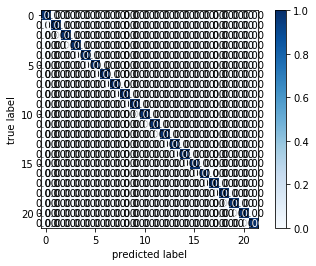

In [29]:
cm = sklearn.metrics.confusion_matrix(test_labels, pred_labels)
print(cm)
#cm = [i/sum(i) for i in cm]


fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
plt.show()

In [30]:
sklearn.metrics.accuracy_score(test_labels, pred_labels)

1.0

In [31]:
# Save the model
f = open('./models/Customs/model_arcface_align_mlp_stranger.pkl', 'wb')
f.write(pickle.dumps(classifier))
f.close()

In [32]:
# Check the effectiveness of Similarity matching
# We use yale dataset as a source of 'stranger' photos. Lets see what happens
 
yales_imgs = loadRawYalesData('./images/validate/')
yales_pre, status = preprocess(yales_imgs)
yales_labels = ['Stranger'] * len(yales_pre)
yales_embs, status = embed(yales_pre, preprocess=False)

In [33]:
print(yales_embs.shape)
print(test_vec.shape)
print(len(yales_labels))

(166, 512)
(53, 512)
166


In [36]:
val_embs = np.concatenate([yales_embs, test_vec])
val_labels = np.concatenate([yales_labels, test_labels])
pred_labels = list()
for i in val_embs:
    name = nameDict[classifier.predict([i])[0]]
    uvecs = vecDict[name]
    if name != 'Stranger':
        print(name)
        val = validateSimilarity(uvecs, i)
        if val is True:
            pred_labels.append(name)
        else:
            print("Person " + name + " Not Verified")
            pred_labels.append('Stranger')
    else:
        pred_labels.append('Stranger')
        
results = [(i,j) for i,j in zip(pred_labels,val_labels)]

Davinder
Similar to 7 Photos of the person out of 7
Abhishek
Similar to 8 Photos of the person out of 9
Nikhil
Similar to 6 Photos of the person out of 7
Nikhil
Similar to 6 Photos of the person out of 7
Ashish
Similar to 6 Photos of the person out of 6
Neha
Similar to 8 Photos of the person out of 10
Santosh
Similar to 7 Photos of the person out of 8
Santosh
Similar to 7 Photos of the person out of 8
Abhishek
Similar to 7 Photos of the person out of 9
Suresh
Similar to 4 Photos of the person out of 4
Davinder
Similar to 7 Photos of the person out of 7
Santosh
Similar to 7 Photos of the person out of 8
LarryPage
Similar to 2 Photos of the person out of 3
AnthonyHopkins
Similar to 2 Photos of the person out of 2
Sonali
Similar to 9 Photos of the person out of 9
Davinder
Similar to 7 Photos of the person out of 7
CPSingh
Similar to 10 Photos of the person out of 11
Surya
Similar to 8 Photos of the person out of 9
Dushyant
Similar to 8 Photos of the person out of 9
Harendra
Similar to 9 P

In [37]:
print(pred_labels)

['Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'Stranger', 'St

FOUND
('Stranger', 'Davinder')
[[  1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0
    0   1   0   0]
 [  0   0   0   0   0   0   0   3   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  

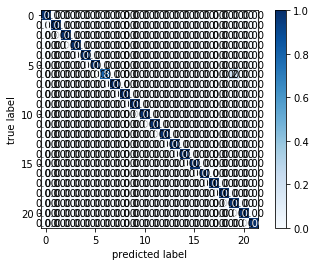

In [38]:
for i in results:
    if i[0] != i[1]:
        print("FOUND")
        print(i)
        
cm = sklearn.metrics.confusion_matrix(val_labels, pred_labels)
print(cm)
#cm = [i/sum(i) for i in cm]


fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
plt.show()

In [87]:
results

[('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 ('Stranger', 'Stranger'),
 

In [144]:
print(test_labels[6], pred_labels[6])

LarryPage Stranger


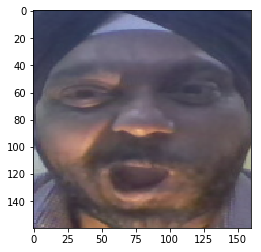

In [83]:
plt.imshow(test_pre[14])

In [38]:
test_labels[:5]

['Abhishek', 'Nikhil', 'Ashish', 'Santosh', 'Abhishek']

In [39]:
json.loads(a.text)

NameError: name 'json' is not defined

In [16]:
import requests as re
import json
import pickle

In [29]:
train_x, test_x, train_y, test_y = train_test_split(imgs,labels,test_size=0)

In [47]:
train_y[10:20]

['Harendra',
 'Neha',
 'Suresh',
 'Jyoti',
 'Harvinder',
 'Nikhil',
 'AnthonyHopkins',
 'Jyoti',
 'Sonali',
 'Harendra']

In [39]:
test_labels

['Abhishek',
 'Nikhil',
 'Ashish',
 'Santosh',
 'Abhishek',
 'Suresh',
 'LarryPage',
 'AnthonyHopkins',
 'Davinder',
 'Sonu',
 'Surya',
 'Harendra',
 'Davinder',
 'CPSingh',
 'Dushyant',
 'MarkZuckerberg',
 'Aayushi',
 'Pankaj',
 'Jyoti',
 'BillGates',
 'Nagesh',
 'Neha',
 'Sonali',
 'Harvinder']

In [42]:
pred_labels

['Abhishek',
 'Neha',
 'Surya',
 'Santosh',
 'Abhishek',
 'Suresh',
 'BillGates',
 'AnthonyHopkins',
 'Davinder',
 'Suresh',
 'Surya',
 'Neha',
 'BillGates',
 'Surya',
 'Dushyant',
 'BillGates',
 'Neha',
 'Santosh',
 'Neha',
 'Dushyant',
 'Abhishek',
 'Neha',
 'Neha',
 'Neha']

In [52]:
c = [i for i,j in zip(pred_labels, test_labels) if i == j]
print(c)
print(len(c))
print(len(c)/len(pred_labels))

['Nikhil', 'Suresh', 'AnthonyHopkins', 'Harendra', 'Jyoti', 'Neha', 'Sonali', 'Harvinder']
8
0.3333333333333333


In [97]:
test_imgs[0].dtype == 'float'

False

In [36]:
preprocess([i for i in test_imgs])

array([[[[0.87120481, 0.87120481, 0.87120481],
         [0.87131204, 0.87131204, 0.87131204],
         [0.87463235, 0.87463235, 0.87463235],
         ...,
         [0.99203431, 0.99203431, 0.99203431],
         [0.99239047, 0.99239047, 0.99239047],
         [0.99571461, 0.99571461, 0.99571461]],

        [[0.8884689 , 0.8884689 , 0.8884689 ],
         [0.89157858, 0.89157858, 0.89157858],
         [0.89522059, 0.89522059, 0.89522059],
         ...,
         [0.98860294, 0.98860294, 0.98860294],
         [0.98863741, 0.98863741, 0.98863741],
         [0.9889591 , 0.9889591 , 0.9889591 ]],

        [[0.89693627, 0.89693627, 0.89693627],
         [0.90036765, 0.90036765, 0.90036765],
         [0.90404412, 0.90404412, 0.90404412],
         ...,
         [0.99433594, 0.99433594, 0.99433594],
         [0.99185432, 0.99185432, 0.99185432],
         [0.99474954, 0.99474954, 0.99474954]],

        ...,

        [[0.08212699, 0.08212699, 0.08212699],
         [0.0758004 , 0.0758004 , 0.0758004 ]

In [17]:
# Create Model
t = re.post("http://localhost:5000/create", data=json.dumps({'user':'ashish'}))

In [128]:
a = re.post("http://localhost:5000/classify", data=json.dumps({'preprocess':True, 'data':[i.tolist() for i in test_imgs], 'user':'ashish', 'type':'img'}))
#[i.tolist() for i in test_imgs[:5]]
#test_imgs.tolist()
pred_labels = json.loads(a.text)

In [53]:
t = re.post("http://localhost:5000/train", data=json.dumps({'preprocess':False, 'data':train_x.tolist(), 'user':'ashish', 'type':'img', 'labels':train_y}))

In [26]:
g = np.array(imgs[:2].tolist())
g.shape

(2, 160, 160, 3)

In [23]:
t = re.post("http://localhost:5000/similarity", data=json.dumps({'img':imgs[1].tolist(), 'data':imgs[7].tolist(), 'user':'help', 'type':'img'}))

In [35]:
a.shape

(12, 512)

In [32]:
a.text

'["AnthonyHopkins"]\n'

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0

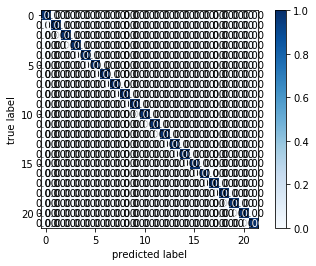

In [126]:
cm = sklearn.metrics.confusion_matrix(test_labels, pred_labels)
print(cm)
#cm = [i/sum(i) for i in cm]


fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
plt.show()

In [56]:
sklearn.metrics.accuracy_score(test_labels, pred_labels)

1.0

In [41]:
del model

In [49]:
import sys
from __future__ import print_function  # for Python2
l = list()
for var, obj in locals().items():
    l.append([sys.getsizeof(var), var])
l = sorted(l)
for i in l:
    print(i)

print(sum((lambda i:[j[0] for j in i])(l)))

[50, '_']
[51, 'In']
[51, '__']
[51, '_i']
[51, 'ax']
[51, 'cm']
[51, 'np']
[51, 'os']
[51, 'pd']
[51, 're']
[51, 'tf']
[52, 'Out']
[52, 'PCA']
[52, 'SVC']
[52, '_14']
[52, '_17']
[52, '_21']
[52, '_22']
[52, '_27']
[52, '_28']
[52, '_36']
[52, '_37']
[52, '_38']
[52, '___']
[52, '_dh']
[52, '_i1']
[52, '_i2']
[52, '_i3']
[52, '_i4']
[52, '_i5']
[52, '_i6']
[52, '_i7']
[52, '_i8']
[52, '_i9']
[52, '_ih']
[52, '_ii']
[52, '_oh']
[52, '_sh']
[52, 'auc']
[52, 'cv2']
[52, 'fig']
[52, 'obj']
[52, 'plt']
[52, 'sys']
[52, 'var']
[53, '_i10']
[53, '_i11']
[53, '_i12']
[53, '_i13']
[53, '_i14']
[53, '_i15']
[53, '_i16']
[53, '_i17']
[53, '_i18']
[53, '_i19']
[53, '_i20']
[53, '_i21']
[53, '_i22']
[53, '_i23']
[53, '_i24']
[53, '_i25']
[53, '_i26']
[53, '_i27']
[53, '_i28']
[53, '_i29']
[53, '_i30']
[53, '_i31']
[53, '_i32']
[53, '_i33']
[53, '_i34']
[53, '_i35']
[53, '_i36']
[53, '_i37']
[53, '_i38']
[53, '_i39']
[53, '_i40']
[53, '_i41']
[53, '_i42']
[53, '_i43']
[53, '_i44']
[53, '_i45']
[53,

In [51]:
sys.getsizeof(imgs)

52224144

In [53]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' By Fred Cirera, after https://stackoverflow.com/a/1094933/1870254'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name,value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name,sizeof_fmt(size)))

                          imgs:  49.8MiB
                     test_imgs:  14.1MiB
                          embs: 170.1KiB
                             X: 170.1KiB
                           _28:  88.0KiB
                            cm:   3.9KiB
                           SVC:   2.0KiB
                             l:   1.9KiB
                          _i23:   1.3KiB
                           _i8:   1.3KiB


In [12]:
import cv2

In [11]:
camera = cv2.VideoCapture(0)

In [41]:
ret, frame = camera.read()

In [42]:
frame.shape

(480, 640, 3)

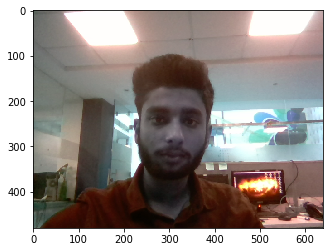

In [43]:
plt.imshow(frame)

In [58]:
n = prewhiten(aligned[0])


W0520 12:40:40.647694 140634822248256 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


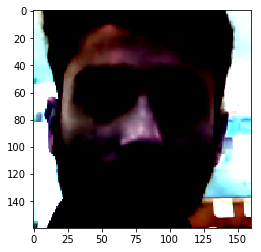

In [59]:
plt.imshow(n)

In [96]:
def align_images(images, margin = 70, image_size = 160):
        try:
            aligned_images = []
            cascade = cv2.CascadeClassifier(cascade_path)
            for img in images:
                #print(filepath)
                if type(img) is list:
                    img = np.array(img)
                img = to_rgb(img)
                try:
                    faces = cascade.detectMultiScale(img,
                                                    scaleFactor=1.1,
                                                    minNeighbors=3)
                    (x, y, w, h) = faces[0]
                    print(faces[0].dtype)
                    cropped = img[y-margin//2:y+h+margin//2,
                                x-margin//2:x+w+margin//2, :]
                    print(cropped.dtype)
                except Exception as e:
                    print("error in face detection")
                    print(e)
                    cropped = img
                img = resize(cropped, (image_size, image_size), mode='reflect')
                #if img.dtype in ('uint8', 'int64'):
                    #img = img.astype('float')/255.
                print(cropped)
                print(img)
                
                #plt.imshow(img)
                #plt.show()
                #img = resize(img, (image_size, image_size), mode='reflect')
                #plt.imshow(img)
                #plt.show()
                aligned_images.append(img)
                return np.array(aligned_images)
        except Exception as e:
            print("Error in Preprocess ")
            print(e)
            return None

In [97]:
aligned = align_images([frame], 50)

int32
uint8
[[[167 150 141]
  [168 151 142]
  [169 152 143]
  ...
  [157 157 157]
  [157 157 157]
  [157 157 157]]

 [[165 149 143]
  [165 149 143]
  [166 150 144]
  ...
  [158 157 160]
  [157 156 159]
  [157 156 159]]

 [[165 149 143]
  [166 150 144]
  [166 150 144]
  ...
  [157 159 161]
  [156 158 160]
  [156 158 160]]

 ...

 [[ 92  60  45]
  [ 90  59  44]
  [ 88  57  42]
  ...
  [ 87  65  48]
  [ 87  69  54]
  [ 88  70  55]]

 [[ 90  57  40]
  [ 90  57  40]
  [ 86  53  35]
  ...
  [ 88  64  47]
  [ 87  67  52]
  [ 90  70  55]]

 [[ 84  50  30]
  [ 84  50  29]
  [ 82  48  26]
  ...
  [ 88  64  47]
  [ 87  67  52]
  [ 89  69  54]]]
[[[0.6507037  0.5850787  0.55474782]
  [0.65364871 0.58802371 0.55769282]
  [0.65386029 0.59017023 0.55824621]
  ...
  [0.61568627 0.61280637 0.61871458]
  [0.61464461 0.61176471 0.61672794]
  [0.61464461 0.61176471 0.61672794]]

 [[0.64393382 0.58118873 0.55686275]
  [0.64705882 0.58431373 0.55998775]
  [0.64785539 0.58613568 0.56207108]
  ...
  [0.615686

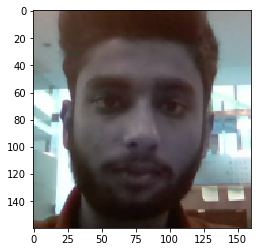

In [89]:
plt.imshow(aligned[0])

In [65]:
del camera